In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

In [158]:
def initialize_plane(N):
    """initializes a matrix of zeros where the top row is 1"""

    #matrix of zeros of NxN
    plane = np.zeros((N,N))

    #first row contains ones
    plane[0] = np.ones(N)

    return plane

def initialize_sinks(N,sinks=0):
    """initializes a matrix of zeros where some areas are 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    #determine dimension of sink
    sink_size = int(N/10)

    #add one sink into the plane
    if sinks == 1:
        #sink in the middle of the plane
        plane[sink_size*4:sink_size*6,sink_size*4:sink_size*6] = 1
    
    #add two sinks into the plane
    if sinks == 2:
        plane[sink_size*6:sink_size*7,sink_size*7:sink_size*8] = 1
        plane[sink_size*2:sink_size*3,sink_size*2:sink_size*3] = 1
    
    return plane

def analytical_solution(y,D,max_i,time):
    """gives the analytical solution for the 2D diffusion equation
    given a coordinate point y, diffusion coefficient D, iterator i and time t
    """

    #count for sum
    solution = 0

    for i in range(max_i):

        #calculate flow from up direction
        up_change = math.erfc((1-y+2*i)/(2*math.sqrt(D*time)))

        #calculate flow from down direction
        down_change = math.erfc((1+y+2*i)/(2*math.sqrt(D*time)))

        #add the difference to solution
        solution += up_change- down_change

    return solution
    

def diffusion(state,dt,dx,D):
    """performs one iteration of the time dependent diffusion equation.
    Given an initial state,timestep dt, spacestep dx and diffusionterm D returns the state at the next timestep.
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through rows (skip first and last one)
    for i in range(1,len(state)-1):
    
        #loop trough columns
        for j in range(len(state)):

            #check for boundaries
            if j == 0:
                
                #take values on the right border of the plane
                left = state[i][-1]
                right = state[i][j+1]
                
            elif j == len(state)-1:
                
                #take values on the left border of the plane
                left = state[i][j-1]
                right = state[i][0]
                
            else:
                
                #take direct left and right neighbors
                left = state[i][j-1]
                right= state[i][j+1]

            #get direct up and down neighbors and current value
            down = state[i+1][j]
            up = state[i-1][j]
            current = state[i][j]

            #calculate diffusion term
            change = D *(dt/(dx**2))

            #calculate value of current cell
            next_state[i][j] = change * (right+left+down+up -(4*current)) + current
        
    return next_state

In [16]:
def jacobi(state,sinks):
    """performs one iteration of the Jacobi method
    Returns the new state of the system
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through rows (skip first and last one)
    for i in range(1,len(state)-1):
    
        #loop trough columns
        for j in range(len(state)):

            #check for sinks
            if sinks[i][j] ==1:
                next_state[i][j]=0
            else:
                #check for boundaries
                if j == 0:
                    
                    #take values on the right border of the plane
                    left = state[i][-1]
                    right = state[i][j+1]
                    
                elif j == len(state)-1:
                    
                    #take values on the left border of the plane
                    left = state[i][j-1]
                    right = state[i][0]
                    
                else:
                    
                    #take direct left and right neighbors
                    left = state[i][j-1]
                    right= state[i][j+1]

                #get direct up and down neighbors
                down = state[i+1][j]
                up = state[i-1][j]

                #calculate value of current cell
                next_state[i][j] = 0.25*(right+left+down+up)
        
    return next_state

In [17]:
def gauss_seidel(state,sinks):
    """performs one iteration of the Gauss Siedel Method
    Returns the new state of the system
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through rows
    for i in range(1,len(state)-1):
    
        #loop trough columns
        for j in range(len(state)):
            
            #check for sinks
            if sinks[i][j]==1:
                next_state[i][j]=0
            else:
                #check for boundaries
                if j == 0:
                    
                    #take values on the right border of the plane
                    left = state[i][-1]
                    right = state[i][j+1]
                    
                elif j == len(state)-1:
                    
                    #take values on the left border of the plane
                    left = next_state[i][j-1]
                    right = state[i][0]
                    
                else:
                    
                    #take direct left and right neighbors
                    left = next_state[i][j-1]
                    right= state[i][j+1]

                #get direct up and down neighbors
                down = state[i+1][j]
                up = next_state[i-1][j]

                #calculate value of current cell
                next_state[i][j] = 0.25*(right+left+down+up)
        
    return next_state


In [18]:
def succesive_over_relaxation(state, mix,sinks):
    """performs one iteration of the Succesive Over Relaxation method
    Given an initial state and mix term omega returns the new state of the system
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through columns
    for i in range(1,len(state)-1):
    
        #loop trough rows (skip first and last one)
        for j in range(len(state)):

            #check for sinks
            if sinks[i][j]==1:
                next_state[i][j] = 0
            else:
            
                #check for boundaries
                if j == 0:
                    
                    #take values on the right border of the plane
                    left = state[i][-1]
                    right = state[i][j+1]
                    
                elif j == len(state)-1:
                    
                    #take values on the left border of the plane
                    left = next_state[i][j-1]
                    right = state[i][0]
                    
                else:
                    
                    #take direct left and right neighbors
                    left = next_state[i][j-1]
                    right= state[i][j+1]

                #get direct up and down neighbors
                down = state[i+1][j]
                up = next_state[i-1][j]

                #calculate value of current cell
                next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])
        
    return next_state


# Plotting

Below we define code for plotting our experiments. The experiments we plot are:

### 1D Wave equation
* Plot the result at several times in the same figure, e.g. varying the color of the curve. Take c = 1 and use the time step ∆t = 0.001
* Make an animated plot of the time development

### Time Dependent Diffusion
* Compare to the analytical solution for t = {0.001, 0.01, 0.1, and 1}.
* Make a plot of the state of the system at several times: t = {0, 0.001, 0.01, 0.1, and 1}.
* Make an animated plot of the time development

### Time Independent Diffusion
* Test the methods by comparing the result to the analytical solution. Use N = 50. 
* Show how the convergence measure δ depends on the number of iterations k with a log-lin plot. For SOR use different values of ω.
* For SOR find the optimal ω. How does it depend on N?
* Experiment a little bit with objects in the computational domain. What is the influence on the number of iterations and the optimal ω.

# 1D Wave equation

# Time Dependent Diffusion

### Time Development + Animation

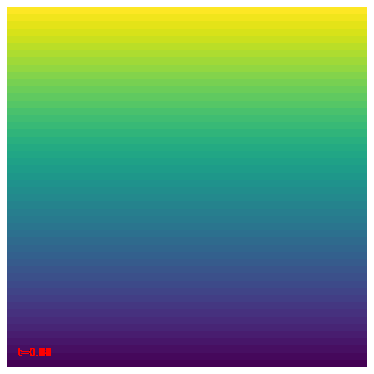

In [82]:
from __future__ import division
 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
 
#Helper class for animation taken from https://tomroelandts.com/articles/how-to-create-animated-gifs-with-python
class AnimatedGif:
    """gif object to add frames to"""
    def __init__(self, size=(500, 500)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label=''):
        """add frame to gif"""
        plt_im = plt.imshow(image, vmin=0, vmax=1, animated=True)
        plt_txt = plt.text(1, 48, label, color='red')
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename,fps=1):
        """save the gif to file"""
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)

#set parameters:
#diffusion coefficient
D = 1
#resolution
N = 50
#timestep dt
time_step = 0.0001
#spacestep dx
space_step = 1/N
#iterations
total_iterations = 10000

#timesteps to plot
saves = [0,10,100,1000,9999]

#list for storing states
states = []

#initialize initial condition
new_state = initialize_plane(N)

#initialize gif object
animated_gif = AnimatedGif()
 
#do the diffusion step for number of iterations
for i in range(total_iterations):

    #get new state of system
    new_state = diffusion(new_state,time_step,space_step,D)

    #save current state if in requested saves
    if i in saves:
        states.append(new_state)
    
    #add every 100th frame to gif
    if i%100==0:
        animated_gif.add(new_state, label=f"t={str(round(i*0.0001,4))}")
    


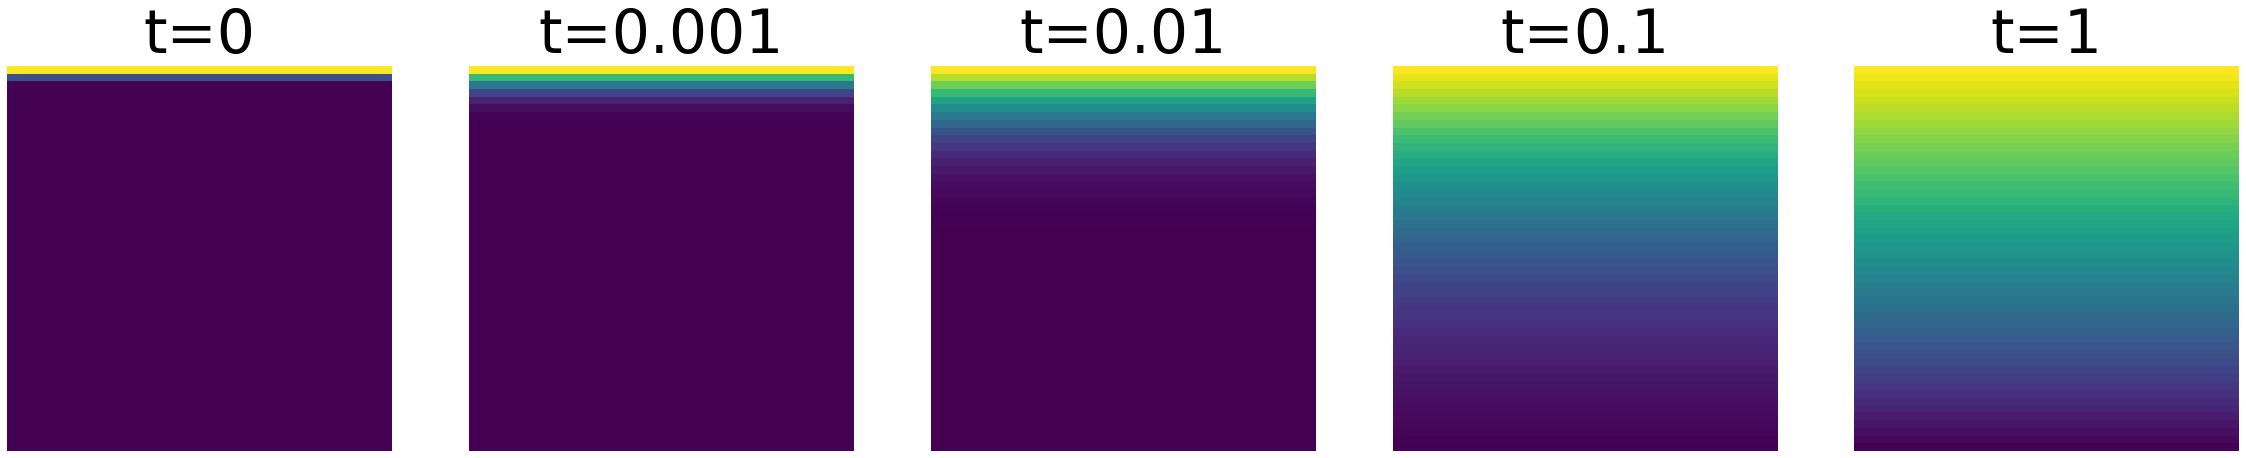

In [100]:
#plot each time as subplots in plot
fig, axs = plt.subplots(1,5,figsize=(40,10))
axs[0].imshow(states[0])
axs[0].set_title('t=0',fontsize=60)
axs[1].imshow(states[1])
axs[1].set_title('t=0.001',fontsize=60)
axs[2].imshow(states[2])
axs[2].set_title('t=0.01',fontsize=60)
axs[3].imshow(states[3])
axs[3].set_title('t=0.1',fontsize=60)
axs[4].imshow(states[4])
axs[4].set_title('t=1',fontsize=60)

#Hide the axes to just show pictures.
for ax in axs:
    ax.label_outer()
    ax.axis('off')


#save the plot
plt.savefig("Figures/diffusion.svg",format="svg", dpi=300)


#save the gif
# animated_gif.save('Gifs/diffusion.gif',fps=10)

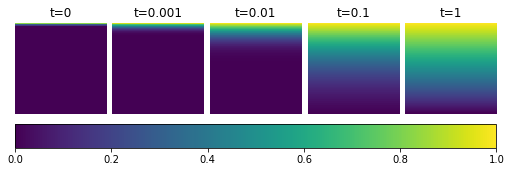

In [127]:
#create a subfigure
fig = plt.figure(constrained_layout=True,figsize=(7,3))
(subfig_l) = fig.subfigures(nrows=1, ncols=1)

#titles:
titles = ["0","0.001","0.01","0.1","1"]

axes_l = subfig_l.subplots(nrows=1, ncols=5, sharey=True)
for i,ax in enumerate(axes_l):
    im = ax.imshow(states[i], vmin=0, vmax=1)
    ax.set_title(f't={titles[i]}')
    ax.label_outer()
    ax.axis('off')

#add the colorbar
subfig_l.colorbar(im, ax=axes_l, location='bottom')

#save the plot
plt.savefig("Figures/diffusion_colorbar.svg",format="svg", dpi=300)

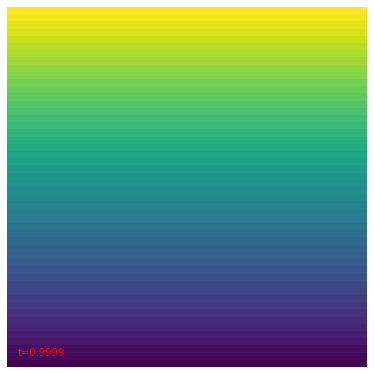

In [77]:
#also make a shorter gif of above plot
#initialize gif object
animated_gif = AnimatedGif()

#add frames
for i in range(len(states)):
    animated_gif.add(states[i], label=f"t={str(round(saves[i]*0.0001,4))}")

#save the gif
animated_gif.save('Gifs/diffusion_short.gif',fps=1)


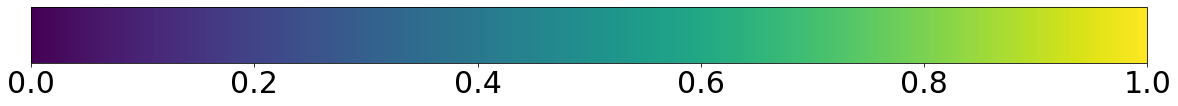

In [34]:
#Save the colobar separately to add it more easily to the graphs later
a = np.array([[0,1]])
plt.figure(figsize=(20, 20))
img = plt.imshow(a)
plt.gca().set_visible(False)
cbar = plt.colorbar(orientation="horizontal")
tick_font_size = 30
cbar.ax.tick_params(labelsize=tick_font_size)
plt.savefig("Figures/colorbar_viridis_horizontal.svg",format="svg", dpi=300)

### Analytical Solution

In [36]:
#Show correctness of time dependent method by comparing to analytical solution

#times to plot
times = [0.001,0.01,0.1,1]

#linspace for i coordinates
coords = np.linspace(0,1,50)

#diffusion coefficient
D = 1

#iterations to evaluate
max_iter = 100

#list for storing all solutions
solutions = []

#calculate values for each time
for time in times:

    #empty array for storing current solution
    solution = np.zeros(len(coords))

    #calculate values for each coordinate
    for j, coord in enumerate(coords):

        #get solution for current coordinate and current time
        solution[j] = analytical_solution(coord,D,max_iter,time)
    
    #add solution to list
    solutions.append(solution)

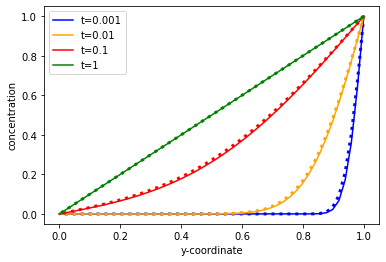

In [41]:
#flip coordinates for numerical states
coords_flip = np.linspace(1,0,50)

#use same colors
colors = ["b","orange","r","g"]

#plot solutions side by side
for i,sol in enumerate(solutions):
    #plot analytical solution
    plt.plot(coords,sol,label=f"t={times[i]}",c=colors[i])
    #plot one column of numerical solution
    plt.plot(coords_flip,states[i+1][:,0],linestyle="dotted",c=colors[i],linewidth=3)

#add labels and legend
plt.xlabel("y-coordinate")
plt.ylabel("concentration")
plt.legend()

#save the plot
plt.savefig("Figures/analytical_comparison.svg",format="svg", dpi=300)


# Time Independent Diffusion

### Analytical comparison + convergence

In [42]:
#initialize initial condition
new_state = initialize_plane(50)

#initialize sinks
sinks = initialize_sinks(50,0)

#set stopping criterion
change = 0.5
epsilon = 10**-5

#mix term for Successive Over Relaxation (SOR)
mix = 1.5

#set count for number of iterations
count = 0

#lists for storing data
final_states = []
convergence_measures = []
convergence_count = []

#do Jacobi iteration until change between states is small enough
convergence = []
convergence.append(change)

#run until change is small
while change>epsilon:

    #save the previous state for now
    prev_state = new_state

    #get new state of system
    new_state = jacobi(new_state,sinks)

    #get difference between new and old state
    difference = np.abs(np.subtract(new_state,prev_state))

    #change is max difference in state
    change = np.max(difference)

    #save current state of convergence measure
    convergence.append(change)

    #increment count
    count +=1

#save the final state for comparison
final_states.append(new_state)

#save the change in convergence measure for comparision
convergence_measures.append(convergence)
 
#reset count and change initial state
count = 0
change = 0.5
new_state = initialize_plane(50)

#do Gauss-Seidel iteration until change between states is small enough
convergence = []
convergence.append(change)

#run for fixed time so all experiments have the same length
while change>epsilon:

    #save the previous state for now
    prev_state = new_state

    #get new state of system
    new_state = gauss_seidel(new_state,sinks)

    #get difference between new and old state
    difference = np.abs(np.subtract(new_state,prev_state))

    #change is max difference in state
    change = np.max(difference)

    #save current state of convergence measure
    convergence.append(change)

    #increment count
    count +=1

#save the final state for comparison
final_states.append(new_state)

#save the change in convergence measure for comparision
convergence_measures.append(convergence)

#mix rates for SOR
mix_rates = [0.1,0.5,1,1.5,1.9]

#do Succesive Over Relaxation iteration until change between states is small enough for different values of Omega (mix)
for mix in mix_rates:

    #reset count and change inital state
    count = 0
    change = 0.5
    new_state = initialize_plane(50)

    #clear list of convergence measures
    convergence = []
    convergence.append(change)

    #run until change is small
    while change>epsilon:

        #save the previous state for now
        prev_state = new_state

        #get new state of system
        new_state = succesive_over_relaxation(new_state,mix,sinks)

        #get difference between new and old state
        difference = np.abs(np.subtract(new_state,prev_state))

        #change is max difference in state
        change = np.max(difference)

        #save current state of convergence measure
        convergence.append(change)

        #increment count
        count +=1

    #save the final state for comparison
    final_states.append(new_state)

    #save the change in convergence measure for comparision
    convergence_measures.append(convergence)


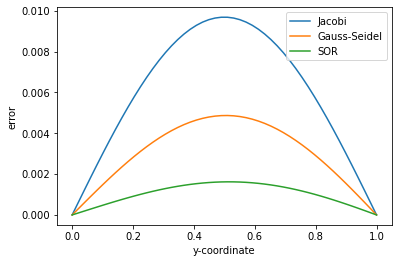

In [44]:
#plot the error from the analytical solution for each method
solution = np.flip(solutions[-1])
plt.plot(coords_flip,solution-final_states[0][:,0],label="Jacobi")
plt.plot(coords_flip,solution-final_states[1][:,0],label="Gauss-Seidel")
plt.plot(coords_flip,solution-final_states[5][:,0],label="SOR")  #SOR with w=1.5

plt.legend()
plt.xlabel("y-coordinate")
plt.ylabel("error")
plt.savefig("Figures/analytical_comparison_indepedent.svg",format="svg", dpi=300)


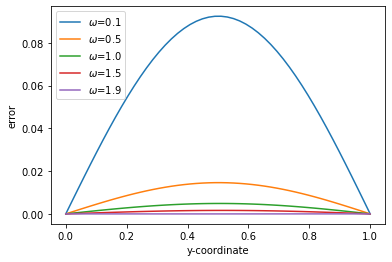

In [45]:
labels = ["$\omega$=0.1","$\omega$=0.5","$\omega$=1.0","$\omega$=1.5","$\omega$=1.9"]

#plot the errors for different values of w
for i in range(2,7):
    plt.plot(coords_flip,solution-final_states[i][:,0],label=labels[i-2])

plt.legend()
plt.xlabel("y-coordinate")
plt.ylabel("error")
plt.savefig("Figures/analytical_comparison_omega.svg",format="svg", dpi=300)


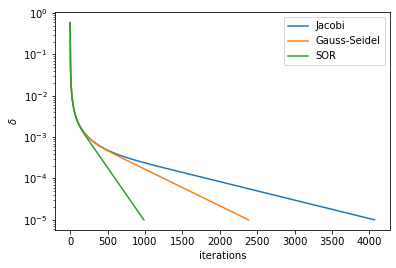

In [47]:
#plot the convergence over time for all methods
plt.plot(convergence_measures[0],label="Jacobi")
plt.plot(convergence_measures[1],label="Gauss-Seidel")
plt.plot(convergence_measures[5],label="SOR")  #SOR with w=1.5

plt.legend()
plt.xlabel("iterations")
plt.ylabel("$\delta$")
plt.yscale("log")
plt.savefig("Figures/comparison_convergence.svg",format="svg", dpi=300)


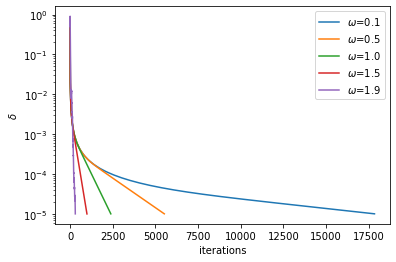

In [48]:

labels = ["$\omega$=0.1","$\omega$=0.5","$\omega$=1.0","$\omega$=1.5","$\omega$=1.9"]

#plot the convergence over time for all SOR with different omega
for i in range(2,7):
    plt.plot(convergence_measures[i],label=labels[i-2])

plt.legend()
plt.xlabel("iterations")
plt.ylabel("$\delta$")
plt.yscale("log")
plt.savefig("Figures/comparison_convergence_omega.svg",format="svg", dpi=300)

### Finding Optimal $\omega$

In [ ]:
from scipy.optimize import minimize

def minimize_omega(omega,initial_state,sinks,solution,epsilon=10**-5):
    """performs SOR for 100 iterations. 
    Returns the error from the analytical solution if no sinks are present.
    Returns amount of iterations when sinks are included
    """

    #initial change is something (rel.) big
    change = 0.5

    #initial count is zero
    count = 0

    #set new state
    new_state = initial_state

    #run for fixed time 
    for i in range(100):

        #save the previous state for now
        prev_state = new_state

        #get new state of system
        new_state = succesive_over_relaxation(new_state,omega,sinks)

        #get difference between new and old state
        difference = np.abs(np.subtract(new_state,prev_state))

        #change is max difference in state
        change = np.max(difference)

        #increment count
        count += 1

    #return error from analytical solution as minimizer
    # error = np.max(np.abs(solution-new_state[:,0]))

    #return difference from previous state as minimizer
    error = change

    return error

In [ ]:
#get resolution sizes to test
N = np.linspace(30,70,5)
# N = np.linspace(30,30,1)

#empty list for storing optimal omega
optimal_omega = []

#number of sinks
num_sinks = 2

#find optimal omega for each N
for n in N:

    #linspace for i coordinates
    coords = np.linspace(0,1,int(n))

    #empty array for storing current solution
    solution = np.zeros(len(coords))

    #calculate analytical values for each coordinate
    for j, coord in enumerate(coords):

        #get solution for current coordinate and current time
        solution[j] = analytical_solution(coord,1,100,1)
    
    #flip solution to be compatible with output of SOR
    solution = np.flip(solution)
    
    #initialize initial state
    initial_state = initialize_plane(int(n))

    #initialize sinks
    sinks = initialize_sinks(int(n),num_sinks)

    #use Scipy's minimize to find optimal omega
    omega = minimize(minimize_omega,1.8, args=(initial_state,sinks,solution),bounds=[(1.7,2.0)])

    #save the optimal omega
    optimal_omega.append(omega.x[0])


In [ ]:
#print the optimal omega for different sizes of the plane (given number of sins)
print(f"ran optimizer for plane with {num_sinks} sinks")
print(N)
print(optimal_omega)

ran optimizer for plane with 2 sinks
[30. 40. 50. 60. 70.]
[1.7864997996877472, 1.8228503412874388, 1.8428829927187698, 1.860497539481315, 1.8788874941796454]


### Adding Sinks

In [49]:
#empty list for storing convergence measures of each experiment
convergence_measures = []

#empty list for storing final state
final_states = []

#empty list for storing sink planes
sink_planes = []

#omega mix term for SOR
mix = 1.85

#plot influence of sinks on the number of iterations
for i in range(3):
    
    #initialize plane
    new_state = initialize_plane(50)

    #initialize sinks
    sinks = initialize_sinks(50,i)

    #save the sink plane for plotting later
    sink_planes.append(sinks)

    #reset change
    change = 0.5 
    
    #empty list for saving convergence measure
    convergence = []

    #run for fixed time so all experiments have the same length
    while change>epsilon:

        #save the previous state for now
        prev_state = new_state

        #get new state of system
        new_state = succesive_over_relaxation(new_state,mix,sinks)

        #get difference between new and old state
        difference = np.abs(np.subtract(new_state,prev_state))

        #change is max difference in state
        change = np.max(difference)

        #save current state of convergence measure
        convergence.append(change)

    #save the final state for comparison
    final_states.append(new_state)

    #save the convergence measure for comparison
    convergence_measures.append(convergence)

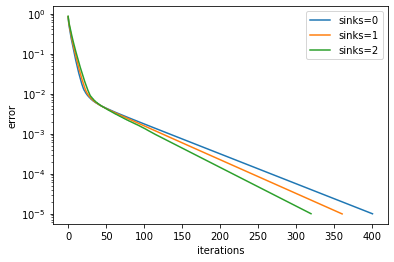

In [129]:
#plot the convergence of SOR for different amount of sinks
plt.plot(convergence_measures[0],label="sinks=0")
plt.plot(convergence_measures[1],label="sinks=1")
plt.plot(convergence_measures[2],label="sinks=2")  

plt.legend()
plt.xlabel("iterations")
plt.ylabel("error")
plt.yscale("log")
# plt.xscale("log")
plt.savefig("Figures/comparison_convergence_sinks.svg",format="svg", dpi=300)

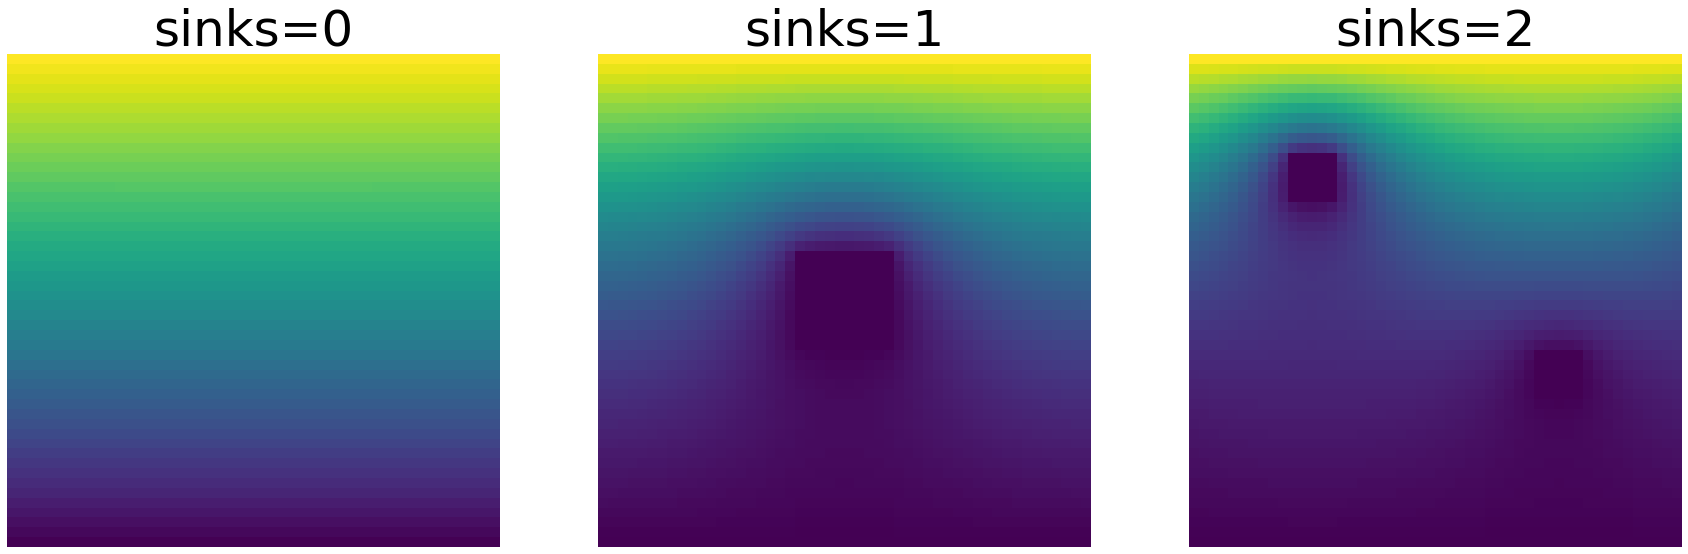

In [92]:
#plot the final states with sinks

#plot each time as subplots in plot
fig, axs = plt.subplots(1,3,figsize=(30,10))
axs[0].imshow(final_states[0])
axs[0].set_title('sinks=0',fontsize=50)
axs[1].imshow(final_states[1])
axs[1].set_title('sinks=1',fontsize=50)
axs[2].imshow(final_states[2])
axs[2].set_title('sinks=2',fontsize=50)

#Hide the axes to just show pictures.
for ax in axs:
    ax.label_outer()
    ax.axis('off')

#save the plot
plt.savefig("Figures/final_states_sinks.svg",format="svg", dpi=300)

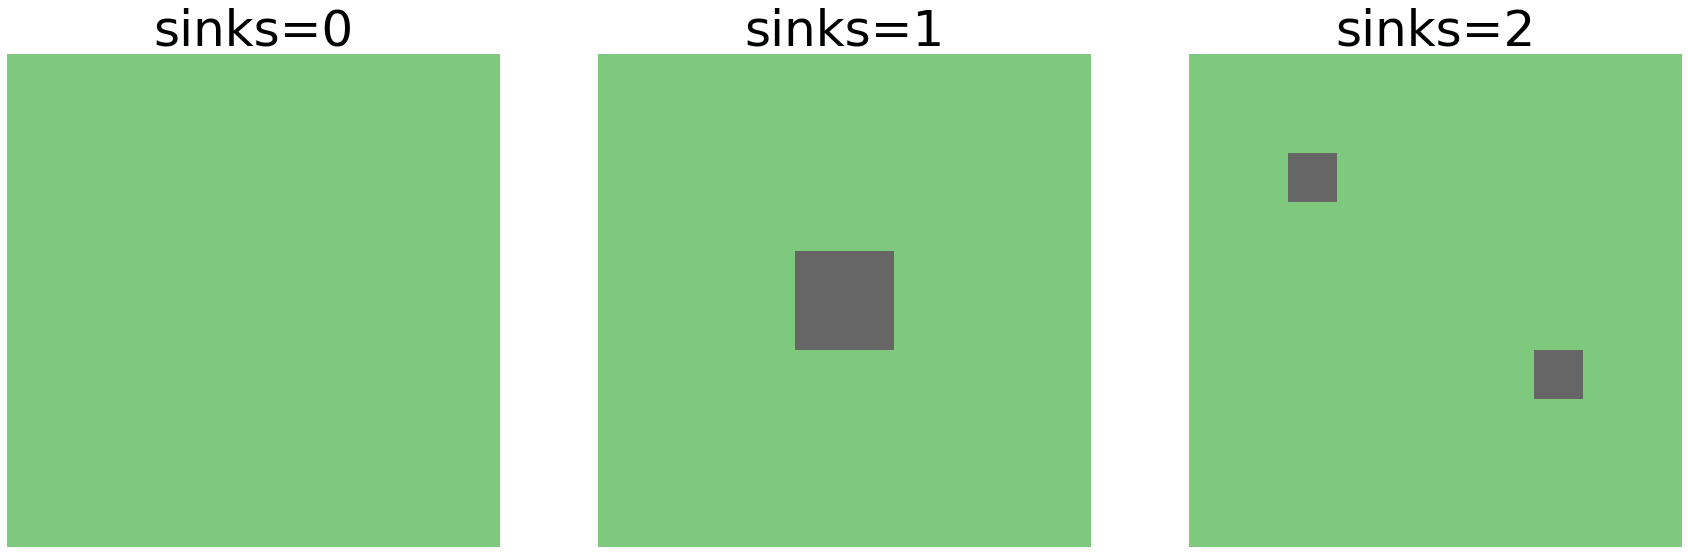

In [93]:
#plot each time as subplots in plot
fig, axs = plt.subplots(1,3,figsize=(30,10))
axs[0].imshow(sink_planes[0],cmap="Accent")
axs[0].set_title('sinks=0',fontsize=50)
axs[1].imshow(sink_planes[1],cmap="Accent")
axs[1].set_title('sinks=1',fontsize=50)
axs[2].imshow(sink_planes[2],cmap="Accent")
axs[2].set_title('sinks=2',fontsize=50)

#Hide the axes to just show pictures.
for ax in axs:
    ax.label_outer()
    ax.axis('off')

#save the plot
plt.savefig("Figures/sinkplanes.svg",format="svg", dpi=300)

In [63]:
#set omega values
omegas = np.linspace(1.8,2.0,10)

#empty list for storing convergence measures of each experiment
convergence_measures = []

#loop through omega values
for omega in omegas:
    
    #initialize plane
    new_state = initialize_plane(50)

    #initialize sinks
    sinks = initialize_sinks(50,0)

    #reset change
    change = 0.5 
    
    #empty list for saving convergence measure
    convergence = []

    #run for fixed time so all experiments have the same length
    while change>epsilon:

        #save the previous state for now
        prev_state = new_state

        #get new state of system
        new_state = succesive_over_relaxation(new_state,omega,sinks)

        #get difference between new and old state
        difference = np.abs(np.subtract(new_state,prev_state))

        #change is max difference in state
        change = np.max(difference)

        #save current state of convergence measure
        convergence.append(change)

    #save the convergence measure for comparison
    convergence_measures.append(convergence)


/tmp/ipykernel_4057/924908141.py:32: RuntimeWarning: overflow encountered in subtract
  difference = np.abs(np.subtract(new_state,prev_state))
/tmp/ipykernel_4057/1747251382.py:44: RuntimeWarning: overflow encountered in double_scalars
  next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])
/tmp/ipykernel_4057/1747251382.py:44: RuntimeWarning: invalid value encountered in double_scalars
  next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])


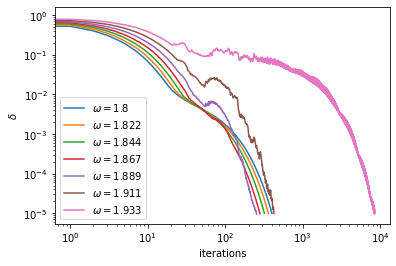

In [78]:
#plot the convergence over time for SOR with different omega on a plane with 1 sink
for i in range(7):
    plt.plot(convergence_measures[i],label="$\omega=$"+str(np.round(omegas[i],3)))

plt.legend()
plt.xlabel("iterations")
plt.ylabel("$\delta$")
plt.yscale("log")
plt.xscale("log")


# plt.savefig()


In [80]:
#set omega values
omegas = np.linspace(1.8,2.0,10)

#empty list for storing convergence measures of each experiment
convergence_measures = []

for i in range(3):
    #loop through omega values
    for omega in omegas:
        
        #initialize plane
        new_state = initialize_plane(50)

        #initialize sinks
        sinks = initialize_sinks(50,i)

        #reset change
        change = 0.5 
        
        #empty list for saving convergence measure
        convergence = []

        #run for fixed time so all experiments have the same length
        while change>epsilon:

            #save the previous state for now
            prev_state = new_state

            #get new state of system
            new_state = succesive_over_relaxation(new_state,omega,sinks)

            #get difference between new and old state
            difference = np.abs(np.subtract(new_state,prev_state))

            #change is max difference in state
            change = np.max(difference)

            #save current state of convergence measure
            convergence.append(change)

        #save the convergence measure for comparison
        convergence_measures.append(convergence)

/tmp/ipykernel_4057/4025037009.py:33: RuntimeWarning: overflow encountered in subtract
  difference = np.abs(np.subtract(new_state,prev_state))
/tmp/ipykernel_4057/1747251382.py:44: RuntimeWarning: overflow encountered in double_scalars
  next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])
/tmp/ipykernel_4057/1747251382.py:44: RuntimeWarning: invalid value encountered in double_scalars
  next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])


/home/maistro/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


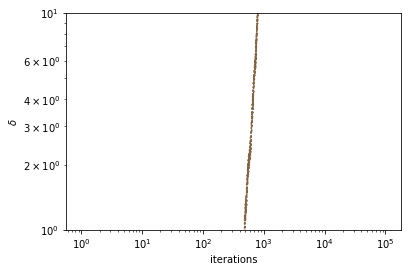

In [130]:
#plot all 
from random import randint
colors = []

for i in range(10):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

# plot the convergence over time for SOR with different omega on a plane with 1 sink
for i in range(6):
    plt.plot(convergence_measures[i],label="$\omega=$"+str(np.round(omegas[i],3)),color=colors[i])
for i in range(10,16):
    plt.plot(convergence_measures[i],label="$\omega=$"+str(np.round(omegas[i-10],3)),linestyle="dashed",color=colors[i-10])
for i in range(20,27):
    plt.plot(convergence_measures[i],label="$\omega=$"+str(np.round(omegas[i-20],3)),linestyle="dotted",color=colors[i-20])

# plt.legend()
plt.xlabel("iterations")
plt.ylabel("$\delta$")
plt.yscale("log")
plt.xscale("log")

# Bonus: Insulated Material

In [169]:
def initialize_barrier(N,sinks=0):
    """initializes a matrix of zeros where some rows are 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    #determine dimension of sink
    sink_size = int(N/10)

    #add one sink into the plane
    if sinks == 1:
        #sink in the middle of the plane
        plane[int(N/2)] = 1
    
    #add two sinks into the plane
    if sinks == 2:
        plane[int(N*1/4)] = 1
        plane[int(N*3/4)] = 1
    
    return plane


def diffusion_barrier(state,dt,dx,D,barrier):
    """performs one iteration of the time dependent diffusion equation.
    Given an initial state,timestep dt, spacestep dx and diffusionterm D returns the state at the next timestep.
    Adapted to account for insulating barriers.
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through rows (skip first and last one)
    for i in range(1,len(state)-1):
    
        #loop trough columns
        for j in range(len(state)):

            #check for insulating material
            if barrier[i][j] ==1:
                D = 0.01
            else:
                D = 1 
                
            #check for boundaries
            if j == 0:
                
                #take values on the right border of the plane
                left = state[i][-1]
                right = state[i][j+1]
                
            elif j == len(state)-1:
                
                #take values on the left border of the plane
                left = state[i][j-1]
                right = state[i][0]
                
            else:
                
                #take direct left and right neighbors
                left = state[i][j-1]
                right= state[i][j+1]

            #get direct up and down neighbors and current value
            down = state[i+1][j]
            up = state[i-1][j]
            current = state[i][j]

            #calculate diffusion term
            change = D *(dt/(dx**2))

            #calculate value of current cell
            next_state[i][j] = change * (right+left+down+up -(4*current)) + current
        
    return next_state

#initialize insulating material in the plane
barrier = initialize_barrier(50,1)

# #set parameters:
#diffusion coefficient
D = 1
#resolution
N = 50
#timestep dt
time_step = 0.0001
#spacestep dx
space_step = 1/N
#iterations
total_iterations = 10000

#timesteps to plot
saves = [0,10,100,1000,9999]

#list for storing states
states = []

#initialize initial condition
new_state = initialize_plane(N)

#initialize gif object
animated_gif = AnimatedGif()
 
#do the diffusion step for number of iterations
for i in range(total_iterations):

    #get new state of system
    new_state = diffusion_barrier(new_state,time_step,space_step,D,barrier)

    #save current state if in requested saves
    if i in saves:
        states.append(new_state)
    
    #add every 100th frame to gif
    if i%100==0:
        animated_gif.add(new_state, label=f"t={str(round(i*0.0001,4))}")


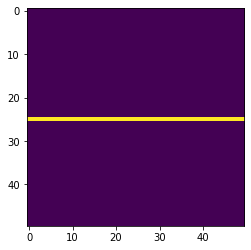

In [170]:
#plot each time as subplots in plot
fig, axs = plt.subplots(1,5,figsize=(40,10))
axs[0].imshow(states[0])
axs[0].set_title('t=0',fontsize=60)
axs[1].imshow(states[1])
axs[1].set_title('t=0.001',fontsize=60)
axs[2].imshow(states[2])
axs[2].set_title('t=0.01',fontsize=60)
axs[3].imshow(states[3])
axs[3].set_title('t=0.1',fontsize=60)
axs[4].imshow(states[4])
axs[4].set_title('t=1',fontsize=60)

#Hide the axes to just show pictures.
for ax in axs:
    ax.label_outer()
    ax.axis('off')


#save the plot
plt.savefig("Figures/diffusion_barrier2.svg",format="svg", dpi=300)

#save the gif
animated_gif.save('Gifs/diffusion_barrier2.gif',fps=10)

#save the barrier plane
plt.imshow(barrier)
plt.savefig("Figures/barrier2.svg",format="svg", dpi=300)